# Load Model

In [1]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import os
import glob

import tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\tensorflow\pyth

In [2]:
def select_model(model_name=None):
    model_dir = r'..\output\model\\'
    if model_name==None:
        file_type = '*h5'
        files = glob.glob(model_dir+file_type)
        max_file = max(files, key=os.path.getctime)
        model = load_model(max_file)
        model_name = os.path.basename(max_file).split('.')[0]
        print('Using model "{}""' .format(max_file))
    else:
        file_name = model_dir+model_name
        model = load_model(file_name)
        model_name = os.path.basename(file_name).split('.')[0]
        print('Using model "{}""' .format(file_name))
    return model, model_name

In [3]:
selected_model = select_model()
model = selected_model[0]
model_name = selected_model[1]
model.summary()

Using model "..\output\model\basic_CNN 20210516-204142.h5""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 63, 63, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 29, 29, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13456)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               1614840   
_________________________________________________________________
dense_1 (Dense) 

# Load and Prepare Test Data

In [4]:
test_dir = r'..\data\cell_images\test'
malaria_dir = os.path.join(test_dir,'Parasitized')
healthy_dir = os.path.join(test_dir,'Uninfected')

malaria_img = glob.glob(malaria_dir+'/*.png')
healthy_img = glob.glob(healthy_dir+'/*.png')

print('Malaria test images : %d' %len(malaria_img))
print('Healthy test images : %d' %len(healthy_img))

Malaria test images : 100
Healthy test images : 100


In [5]:
data_frac = 1

df = pd.DataFrame({
    'img': malaria_img + healthy_img,
    'label': ['malaria']*len(malaria_img) + ['healthy']*len(healthy_img)
}).sample(frac=data_frac).reset_index(drop=True)

img_num = df.shape[0]

df.head()

,img,label
0,..\data\cell_images\test\Uninfected\C151P112Th...,healthy
1,..\data\cell_images\test\Parasitized\C174P135N...,malaria
2,..\data\cell_images\test\Parasitized\C100P61Th...,malaria
3,..\data\cell_images\test\Parasitized\C174P135N...,malaria
4,..\data\cell_images\test\Parasitized\C174P135N...,malaria


In [6]:
resize = (130,130)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df,
    directory = None,
    x_col = 'img',
    y_col = 'label',
    target_size = resize,
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False,
)

Found 200 validated image filenames belonging to 2 classes.


# Scores by Test Data

In [7]:
scores = model.evaluate_generator(generator=test_generator)
print('Accuracy = {0:.2f} %' .format(scores[1]))
print('Loss     = {0:.2f} %' .format(scores[0]))

Accuracy = 0.99 %
Loss     = 0.04 %


# Predict Test Data

In [8]:
prediction = model.predict_generator(generator=test_generator)
predicted_classes = np.around(prediction)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

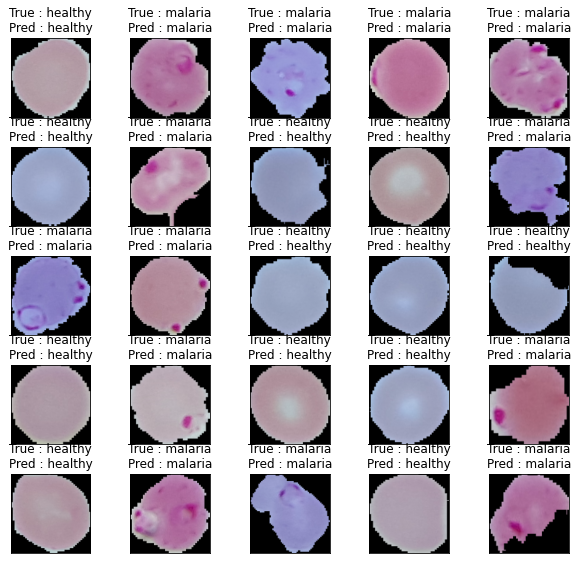

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(1, figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.01,wspace=0.5)
    plt.imshow(cv2.resize(cv2.imread(df.img[i]), resize))
    plt.title('True : {}\nPred : {}'.format(class_labels[true_classes[i]],class_labels[int(predicted_classes[i])]), horizontalalignment='center')
    plt.xticks([])
    plt.yticks([])

output_dir = r'..\output\image\\'
image_name = output_dir+'Test_Prediction_from_'+model_name+'.png'
plt.savefig(image_name)

# Classification Matrix

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     healthy       0.99      1.00      1.00       100
     malaria       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



# Confusion Matrix

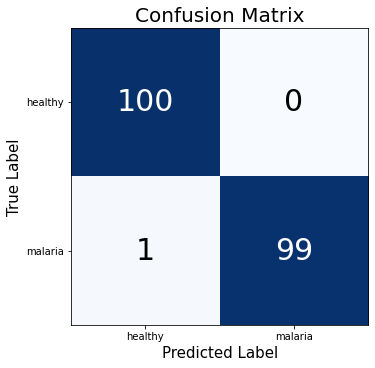

In [11]:
conf_mat = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)

plt.figure(figsize=(5,5))
plt.imshow(conf_mat, interpolation='nearest', cmap='Blues')
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[0]):
        plt.text(j, i, s=format(conf_mat[i,j]), 
                 horizontalalignment='center', verticalalignment='center',
                 size=30, color = 'white' if conf_mat[i][j]>np.max(conf_mat)/2 else 'black')
plt.tight_layout()
plt.ylabel('True Label', fontsize = 15)
plt.xlabel('Predicted Label', fontsize = 15)
plt.title('Confusion Matrix', fontsize = 20)

output_dir = r'..\output\plot\\'
image_name = output_dir+'Confusion_Matrix_from_'+model_name+'.png'
plt.savefig(image_name)

plt.show()